Week 8 · Day 2 — Stronger Augmentation & Regularization
Why this matters

Augmentation makes your training set larger “for free.” By changing colors, erasing patches, or mixing images, CNNs learn to generalize better. Regularization techniques complement this by reducing overfitting — together, they can boost accuracy significantly.

Theory Essentials

ColorJitter: random brightness/contrast/saturation shifts.

RandomErasing (Cutout): mask out random patches → forces robustness.

Mixup/CutMix: blend or patch two images → model learns smoother decision boundaries.

Ablation study: compare baseline vs +aug vs +aug+reg to see the impact.

Tradeoff: too strong augmentation = distorted data, possible underfitting.

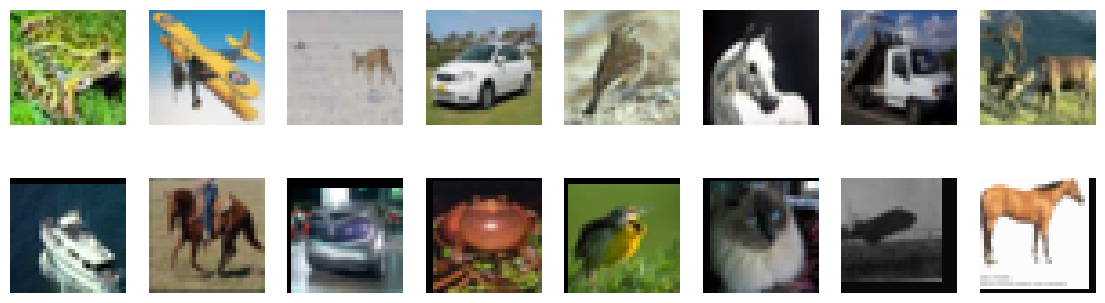

In [5]:
# Setup
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

# ---------- Transforms ----------
baseline_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

aug_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    transforms.RandomErasing(p=0.1, scale=(0.05,0.2), ratio=(0.3,3.3))
])

# ---------- Datasets ----------
train_base = datasets.CIFAR10(root="data", train=True, download=True, transform=baseline_tf)
train_aug  = datasets.CIFAR10(root="data", train=True, download=True, transform=aug_tf)

loader_base = DataLoader(train_base, batch_size=8, shuffle=True)
loader_aug  = DataLoader(train_aug, batch_size=8, shuffle=True)

# ---------- Visualize ----------
imgs_base, _ = next(iter(loader_base))
imgs_aug, _  = next(iter(loader_aug))

fig, axs = plt.subplots(2,8, figsize=(14,4))
for i in range(8):
    axs[0,i].imshow(np.transpose(imgs_base[i].numpy(), (1,2,0))*0.5+0.5)
    axs[0,i].axis("off")
    axs[1,i].imshow(np.transpose(imgs_aug[i].numpy(), (1,2,0))*0.5+0.5)
    axs[1,i].axis("off")
axs[0,0].set_ylabel("Baseline")
axs[1,0].set_ylabel("Augmented")
plt.show()


1) Core (10–15 min)

Task: Add transforms.RandomRotation(15) into aug_tf and visualize.

Insert 'transforms.RandomRotation(15),' before ToTensor


2) Practice (10–15 min)

Task: Try different p values for RandomErasing (0.1 vs 0.7). Which produces stronger augmentation?

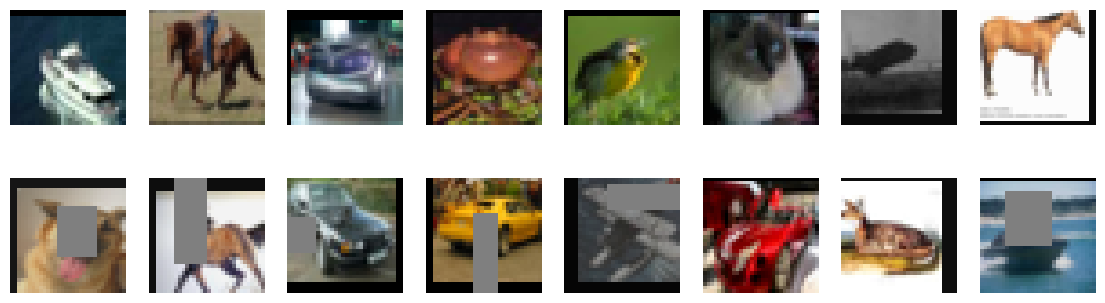

In [10]:
aug_tf_eraser = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    transforms.RandomErasing(p=0.7, scale=(0.05,0.2), ratio=(0.3,3.3))
])

train_aug_eraser  = datasets.CIFAR10(root="data", train=True, download=True, transform=aug_tf_eraser)
loader_aug_eraser  = DataLoader(train_aug_eraser, batch_size=8, shuffle=True)
imgs_aug_eraser, _  = next(iter(loader_aug_eraser))


fig, axs = plt.subplots(2,8, figsize=(14,4))
for i in range(8):
    axs[0,i].imshow(np.transpose(imgs_aug[i].numpy(), (1,2,0))*0.5+0.5)
    axs[0,i].axis("off")
    axs[1,i].imshow(np.transpose(imgs_aug_eraser[i].numpy(), (1,2,0))*0.5+0.5)
    axs[1,i].axis("off")
axs[0,0].set_ylabel("Augemented + eraser 0.1")
axs[1,0].set_ylabel("Augmented + eraser 0.7")
plt.show()

3) Stretch (optional, 10–15 min)

Task: Implement a simple Mixup function that blends two random images.

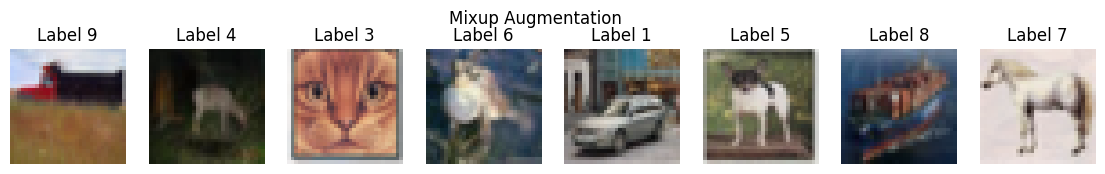

In [11]:
def mixup(x1, y1, x2, y2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    x = lam*x1 + (1-lam)*x2
    y = lam*y1 + (1-lam)*y2
    return x,y

# --- Get two batches ---
imgs1, labels1 = next(iter(loader_base))
imgs2, labels2 = next(iter(loader_base))

# One-hot encode labels for mixup
num_classes = 10
y1 = torch.nn.functional.one_hot(labels1, num_classes=num_classes).float()
y2 = torch.nn.functional.one_hot(labels2, num_classes=num_classes).float()

# Apply mixup
x_mix, y_mix = mixup(imgs1, y1, imgs2, y2, alpha=0.4)

# --- Visualize ---
fig, axs = plt.subplots(1, 8, figsize=(14, 2))
for i in range(8):
    axs[i].imshow(np.transpose((x_mix[i]*0.5+0.5).numpy(), (1,2,0)))
    axs[i].axis("off")
    axs[i].set_title(f"Label {y_mix[i].argmax().item()}")
plt.suptitle("Mixup Augmentation")
plt.show()

Mini-Challenge (≤40 min)

Task:

Train your CIFAR-10 CNN for 5 epochs with:

Baseline preprocessing.

Augmentation pipeline (flip + crop + jitter + erase).

Report validation accuracy for each.

Make a 2-row table (baseline vs +aug).

Acceptance Criteria:

Table shows both accuracies.

Short note: Did augmentation help? If yes, explain why.

In [12]:
# --- Setup (CPU/GPU friendly) ---
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np, pandas as pd, time

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Transforms ---
baseline_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

aug_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    transforms.RandomErasing(p=0.5, scale=(0.05,0.2), ratio=(0.3,3.3)),
])

val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# --- Data (train/val split) ---
full_train = datasets.CIFAR10(root="data", train=True, download=True, transform=None)
N = len(full_train)  # 50_000
n_val = 5_000
n_train = N - n_val
train_set, val_set = random_split(full_train, [n_train, n_val], generator=torch.Generator().manual_seed(42))

# we’ll swap in transforms later to keep the same split
val_set.dataset.transform = val_tf

def make_loader(ds, batch_size=128, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=(device.type=="cuda"))

val_loader = make_loader(val_set, shuffle=False)

# --- Simple CNN (3 conv blocks) ---
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),      # 32x16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),     # 64x8x8
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),    # 128x4x4
            nn.Flatten(),
            nn.Linear(128*4*4, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.net(x)

# --- Train / Eval helpers ---
def accuracy(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)
    return correct/total

def run_experiment(name, train_tf, epochs=5, lr=1e-3):
    # attach transform to training split (same indices)
    train_set.dataset.transform = train_tf

    train_loader = make_loader(train_set, shuffle=True)
    model = SmallCNN().to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # small WD for stability
    criterion = nn.CrossEntropyLoss()

    for ep in range(1, epochs+1):
        model.train()
        t0, running = time.time(), 0.0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            opt.step()
            running += loss.item()*y.size(0)
        val_acc = accuracy(model, val_loader)
        print(f"[{name}] Epoch {ep:02d}/{epochs} | train_loss={running/len(train_loader.dataset):.4f} | val_acc={val_acc*100:.2f}% | {time.time()-t0:.1f}s")

    return accuracy(model, val_loader)

# --- Run both experiments ---
torch.manual_seed(42)  # reproducibility across runs
acc_base = run_experiment("BASELINE", baseline_tf, epochs=5)

torch.manual_seed(42)
acc_aug  = run_experiment("AUGMENTED", aug_tf, epochs=5)

# --- Results table + short note ---
df = pd.DataFrame({
    "Setup": ["Baseline", "Flip+Crop+Jitter+Erase"],
    "Val Accuracy (%)": [round(acc_base*100, 2), round(acc_aug*100, 2)]
})
print("\nResults:")
print(df.to_string(index=False))

note = ("Augmentation helped (higher accuracy) because it increases data diversity, "
        "makes the model robust to small translations/lighting changes, and reduces overfitting.")
if acc_aug <= acc_base:
    note = ("In this short 5-epoch run augmentation did not beat baseline. With more epochs or tuned hyperparameters, "
            "aug usually helps by fighting overfitting. You can try stronger/weaker jitter, different erase p/scale, "
            "or longer training.")
print("\nShort note:", note)


[BASELINE] Epoch 01/5 | train_loss=1.5497 | val_acc=54.34% | 89.0s
[BASELINE] Epoch 02/5 | train_loss=1.1511 | val_acc=62.88% | 78.9s
[BASELINE] Epoch 03/5 | train_loss=0.9657 | val_acc=68.66% | 81.0s
[BASELINE] Epoch 04/5 | train_loss=0.8361 | val_acc=71.70% | 80.3s
[BASELINE] Epoch 05/5 | train_loss=0.7368 | val_acc=73.48% | 110.7s
[AUGMENTED] Epoch 01/5 | train_loss=1.7592 | val_acc=44.90% | 128.6s
[AUGMENTED] Epoch 02/5 | train_loss=1.4702 | val_acc=49.70% | 128.5s
[AUGMENTED] Epoch 03/5 | train_loss=1.3389 | val_acc=53.16% | 130.9s
[AUGMENTED] Epoch 04/5 | train_loss=1.2382 | val_acc=59.52% | 229.3s
[AUGMENTED] Epoch 05/5 | train_loss=1.1439 | val_acc=61.74% | 233.2s

Results:
                 Setup  Val Accuracy (%)
              Baseline             73.48
Flip+Crop+Jitter+Erase             62.66

Short note: In this short 5-epoch run augmentation did not beat baseline. With more epochs or tuned hyperparameters, aug usually helps by fighting overfitting. You can try stronger/weak

Notes / Key Takeaways

Augmentation simulates dataset diversity → stronger generalization.

Color jitter teaches model to ignore lighting/contrast shifts.

Random erasing = robustness to occlusion.

Mixup/CutMix enforce smoother decision boundaries.

Always compare baseline vs augmented (ablation).

Reflection

Why might augmentation improve validation accuracy even if training accuracy drops?

What’s the risk of applying too strong augmentation?

1) Why might augmentation improve validation accuracy even if training accuracy drops?

Augmentation makes training harder (the network sees distorted/noisy versions of images).

That usually reduces training accuracy because the model can’t memorize perfectly.

But it improves generalization: the model learns features that are robust to flips, crops, lighting, etc.

On unseen validation/test images, those robust features help → higher validation accuracy.

2) What’s the risk of applying too strong augmentation?

If transformations are too aggressive (e.g. cropping away most of the object, heavy color distortion), the model may struggle to learn the true patterns.

This can lead to underfitting → both training and validation accuracy suffer.

The key is balance: enough augmentation to prevent overfitting, but not so much that the data no longer represents the real distribution.